<a href="https://colab.research.google.com/github/julianamorenor/DeepLearning/blob/main/Proyecto_Deep_Learning_Juliana_Moreno_Rada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Proyecto Final: Fundamentos de Deep Leaning**

###**Detección de demencia a partir de imágenes de resonancia magnética**

En este proyecto se hará uso de imágenes de un dataset obtenido en Kaggle para hacer una clasificación de imagenes de resonancia e identificar si la imagen corresponde a un cerebro de una persona con demencia avanzada, o una persona sana.

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
import cv2
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from sklearn.metrics import confusion_matrix
import random


Instalamos las dependencias

In [ ]:
!pip install wget
!pip install zipfile
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=077d804149506c297ffca3986a237eeb79ee182f12c860a41ef51bb7fe0289b7
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Para poder traer los datos del repositorio, debemos cargar el "api token" que permite hacer uso de las imágenes

In [ ]:
from google.colab import files

# Carga el archivo kaggle.json desde tu máquina local
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"julianamorenorada","key":"ddf6371030832c0668e137cb63e002a0"}'}

### **Selección de datos, preprocesado y definición de conjuntos de entrenamiento y prueba**

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset

augmented-alzheimer-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
dataset_path = '/content/augmented-alzheimer-mri-dataset.zip'
extract_path = '/content/data'

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Se definen los parámetros para generación de los conjuntos de prueba y validación

In [ ]:
data_dir = '/content/data/OriginalDataset'
image_size = (64, 64)  # se ajusta el tamaño de imagen
batch_size = 1024
#classes = ['MildDemented', 'ModerateDemented','NonDemented','VeryMildDemented']
classes = ['NonDemented','VeryMildDemented']

Se crean los directorios

In [ ]:
train_dir = '/content/data/OriginalDataset/train'
test_dir = '/content/data/OriginalDataset/test'
# Crear directorios de entrenamiento y prueba
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [ ]:
# Crear directorios de entrenamiento y prueba para cada clase
for class_name in classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

Se hace la separación de imágenes

In [ ]:
# Mover imágenes a los directorios correspondientes
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    image_files = os.listdir(class_dir)
    train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)

    for image_file in train_files:
        src_path = os.path.join(class_dir, image_file)
        dst_path = os.path.join(train_dir, class_name, image_file)
        shutil.move(src_path, dst_path)

    for image_file in test_files:
        src_path = os.path.join(class_dir, image_file)
        dst_path = os.path.join(test_dir, class_name, image_file)
        shutil.move(src_path, dst_path)

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)  # Se instacia un clase generadora de imagenes y se normalizan de los valores de píxeles
#datagen =ImageDataGenerator(rescale=1.0/255.0, color_mode='grayscale')

Se generan los conjuntos de prueba y entrenamiento

In [ ]:
# Generar conjuntos de entrenamiento
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    #color_mode='grayscale',
    shuffle=True
)

Found 4352 images belonging to 2 classes.


In [ ]:
# Generar conjuntos de prueba
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    #color_mode='grayscale',
    shuffle=False
)

Found 1088 images belonging to 2 classes.


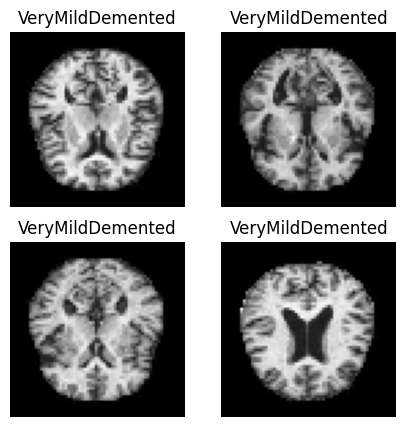

In [ ]:
plt.figure(figsize=(5, 5))
for images, labels in train_generator:
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i])
        plt.title(classes[np.argmax(labels[i])])
        plt.axis("off")
    break

## **Diseño del modelo**

In [ ]:
#Conteo de imágenes de cada clase para entrenamiento
class_counts = dict()
for folder in classes:
    class_counts[folder] = len(os.listdir(train_dir+'/'+folder))

class_counts

{'NonDemented': 2560, 'VeryMildDemented': 1792}

In [ ]:
#Conteo de imágenes de cada clase para prueba
class_counts = dict()
for folder in classes:
    class_counts[folder] = len(os.listdir(test_dir+'/'+folder))

class_counts

{'NonDemented': 640, 'VeryMildDemented': 448}

In [ ]:
labels = train_generator.class_indices
labels

{'NonDemented': 0, 'VeryMildDemented': 1}

In [ ]:
x, y = train_generator.next()
print("Forma de los datos de entrada:", x.shape)
print("Forma de las etiquetas:", y.shape)

Forma de los datos de entrada: (1024, 64, 64, 3)
Forma de las etiquetas: (1024, 2)


In [ ]:
y[0] #one hot ecoder

array([1., 0.], dtype=float32)

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras import models, layers

In [ ]:
#model = models.Sequential()
#model.add(base_model)
#model.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(2, activation='softmax'))
#opt = tf.keras.optimizers.Adam(learning_rate=0.1)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model1 = models.Sequential()
model1.add(base_model)
model1.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(2, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2)                 16386     
                                                                 
Total params: 23,604,098
Trainable params: 16,386
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
model1.fit(train_generator,batch_size=1024, epochs=10,validation_data=test_generator)
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model1.evaluate(test_generator)

In [ ]:
model.fit(train_generator,batch_size=1024, epochs=10,validation_data=test_generator)
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(test_generator)

Epoch 1/10
14/14 [==============================] - 367s 26s/step - loss: 10.3605 - accuracy: 0.5100 - val_loss: 4.7046 - val_accuracy: 0.4838
Epoch 2/10
14/14 [==============================] - 397s 29s/step - loss: 3.2171 - accuracy: 0.5171 - val_loss: 1.2979 - val_accuracy: 0.6000
Epoch 3/10
14/14 [==============================] - 406s 30s/step - loss: 1.5079 - accuracy: 0.5776 - val_loss: 1.2826 - val_accuracy: 0.5575
Epoch 4/10
14/14 [==============================] - 411s 30s/step - loss: 1.0967 - accuracy: 0.5749 - val_loss: 0.6802 - val_accuracy: 0.6444
Epoch 5/10
14/14 [==============================] - 399s 29s/step - loss: 0.8034 - accuracy: 0.6033 - val_loss: 0.6536 - val_accuracy: 0.6345
Epoch 6/10
14/14 [==============================] - 401s 29s/step - loss: 0.7019 - accuracy: 0.6159 - val_loss: 0.6791 - val_accuracy: 0.6071
Epoch 7/10
14/14 [==============================] - 402s 29s/step - loss: 0.7578 - accuracy: 0.5967 - val_loss: 0.6619 - val_accuracy: 0.6168
Epoch

In [ ]:
pred = model.predict(test_generator)

5/5 [==============================] - 88s 17s/step


In [ ]:
y_true = test_generator.labels
y_pred_labels = np.argmax(pred, axis=1)

In [ ]:
report = classification_report(y_true, y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.36      0.50      2400
           1       0.57      0.90      0.70      2240

    accuracy                           0.62      4640
   macro avg       0.69      0.63      0.60      4640
weighted avg       0.69      0.62      0.59      4640



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout

In [ ]:
def get_conv_model(data_size, compile=True):
  inputs = tf.keras.Input(shape=data_size, name="input")
  layers= tf.keras.layers.Conv2D(128, (7, 7), activation='relu')(inputs)
  layers = tf.keras.layers.MaxPool2D((2, 2))(layers)
  layers= tf.keras.layers.Conv2D(64, (5, 5), activation='relu')(layers)
  layers = tf.keras.layers.MaxPool2D((2, 2))(layers)
  #layers= tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(layers)
  #layers = tf.keras.layers.MaxPool2D((2, 2))(layers)
  layers = tf.keras.layers.Flatten()(layers)
  layers = tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.01))(layers)
  #layers = tf.keras.layers.Dense(16, activation='relu')(layers)
  layers = tf.keras.layers.Dropout(0.3)(layers)
  predictions = tf.keras.layers.Dense(2, activation='softmax')(layers)
  model = tf.keras.Model(inputs = inputs, outputs=predictions)
  opt = tf.keras.optimizers.Adam(learning_rate=0.1)
  if compile:
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

  return model

In [ ]:
def get_conv1_model(data_size,compile=True):
     inputs = tf.keras.Input(shape=data_size, name="input")
     layers = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(inputs)
     layers=tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(layers)
     layers = tf.keras.layers.MaxPooling2D((2, 2),)(layers)

     layers = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(layers)
     layers = tf.keras.layers.MaxPooling2D((2, 2))(layers)

     layers = tf.keras.layers.Conv2D(512, (3, 3), activation='relu')(layers)
     layers = tf.keras.layers.Conv2D(512, (3, 3), activation='relu')(layers)
     layers = tf.keras.layers.MaxPooling2D((2, 2))(layers)



     layers = tf.keras.layers.Flatten()(layers)
     #layers = tf.keras.layers.BatchNormalization()(layers)
     layers = tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(layers)
     layers = tf.keras.layers.Dropout(0.3)(layers)
     predictions = tf.keras.layers.Dense(2, activation='softmax')(layers)
     model = tf.keras.Model(inputs = inputs, outputs=predictions)
     opt = tf.keras.optimizers.Adam(learning_rate=0.1)
     if compile:
      model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
     return model

In [ ]:
def get_conv2_model(data_size, compile=True):
    model = Sequential()
    model.add(Conv2D(128, (7, 7), activation='relu', input_shape=data_size))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    #inputs = tf.keras.Input(shape=data_size, name="input")
    #layers= tf.keras.layers.Conv2D(128, (7, 7), activation='relu')(inputs)
    #layers = tf.keras.layers.MaxPool2D((2, 2))(layers)
    #layers= tf.keras.layers.Conv2D(64, (5, 5), activation='relu')(layers)
    #layers = tf.keras.layers.MaxPool2D((2, 2))(layers)
    #layers= tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(layers)
    #layers = tf.keras.layers.MaxPool2D((2, 2))(layers)
    #layers = tf.keras.layers.Flatten()(layers)
    #layers = tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.01))(layers)
    #layers = tf.keras.layers.Dense(16, activation='relu')(layers)
    #layers = tf.keras.layers.Dropout(0.3)(layers)
    #predictions = tf.keras.layers.Dense(2, activation='softmax')(layers)
    #model = tf.keras.Model(inputs = inputs, outputs=predictions)
    #loss_function = tf.keras.losses.BinaryCrossentropy()
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.1)
    if compile:
        model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

    return model

In [ ]:
model2 = get_conv1_model(data_size=(64, 64, 3),compile=True)
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 block2_conv1 (Conv2D)       (None, 30, 30, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                         

In [ ]:
model = get_conv1_model(data_size=(64, 64, 3),compile=True)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 block2_conv1 (Conv2D)       (None, 30, 30, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                       

In [ ]:
model2.fit(train_generator, epochs=10,validation_data=test_generator)
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model2.evaluate(test_generator)

Epoch 1/10


KeyboardInterrupt: ignored

In [ ]:
model.fit(train_generator, epochs=10,validation_data=test_generator)
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(test_generator)


Epoch 1/10
15/15 [==============================] - 1538s 102s/step - loss: 198.7582 - accuracy: 0.5051 - val_loss: 42566116.0000 - val_accuracy: 0.5178
Epoch 2/10
15/15 [==============================] - 1574s 105s/step - loss: 58.4219 - accuracy: 0.4995 - val_loss: 55.9541 - val_accuracy: 0.5226
Epoch 3/10
15/15 [==============================] - 1566s 105s/step - loss: 42.3695 - accuracy: 0.5018 - val_loss: 193.6935 - val_accuracy: 0.4685
Epoch 4/10
15/15 [==============================] - 1559s 104s/step - loss: 67.8071 - accuracy: 0.5004 - val_loss: 129.4557 - val_accuracy: 0.5154
Epoch 5/10
15/15 [==============================] - 1563s 105s/step - loss: 56.1958 - accuracy: 0.5084 - val_loss: 71.3141 - val_accuracy: 0.5172
Epoch 6/10
15/15 [==============================] - 1528s 102s/step - loss: 50.1668 - accuracy: 0.5053 - val_loss: 96.2390 - val_accuracy: 0.4574
Epoch 7/10
15/15 [==============================] - 1570s 105s/step - loss: 52.3025 - accuracy: 0.5039 - val_loss: 

In [ ]:
pred = model.predict(test_generator)
y_true = test_generator.labels
y_pred_labels = np.argmax(pred, axis=1)

4/4 [==============================] - 109s 23s/step


In [ ]:
y_pred_labels[0:5]

array([1, 0, 1, 1, 1])

In [ ]:
report = classification_report(y_true, y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.42      0.14      0.21      1920
           1       0.46      0.79      0.58      1792

    accuracy                           0.45      3712
   macro avg       0.44      0.46      0.40      3712
weighted avg       0.44      0.45      0.39      3712



In [ ]:
cm = confusion_matrix(y_true, y_pred_labels)

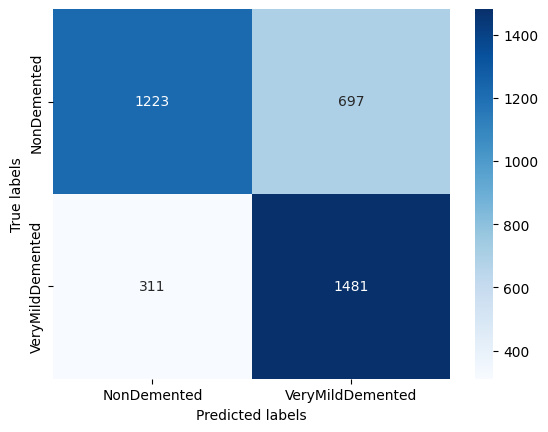

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()